# requirements.txt

pip install keras==2.2.3 scikit-learn==0.19.0 tensorflow-gpu==1.15.0

pydot  if you have graphdot

source code is from https://github.com/smousavi05/Unsupervised_Deep_Learning

the file is from https://github.com/smousavi05/Unsupervised_Deep_Learning/blob/master/unsupervised_deep_learning.ipynb

In [1]:
from __future__ import print_function
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
import tensorflow.keras
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.engine.topology import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import idac_metrics as metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

Using TensorFlow backend.


In [2]:
import logging
logging.disable(30)   # disable the deprecated warning from tensorflow

# Loading the data

data in original paper

x = np.load('x.np.npy') # STFT of local and teleseismic waveforms
y = np.load('y.np.npy') # labels
n_clusters = 2

the shape is (size, 16, 48, 1)

Next, we will read our data

In [3]:
from scipy.io import loadmat
train_data = loadmat('earthb.mat')
all_data = train_data['images']
all_target = train_data['labels']

In [4]:
n_clusters = 3

In [5]:
from data_utils import get_data


data = get_data(all_data, all_target, dataset='eq', seed=1, shape=[-1, 40, 40, 1], select=[100, 1700], norm=True)


2022-07-15 13:05:24.342 | INFO     | data_utils:normalization:12 - Normalization in range [-0.5657, 0.5392]


In [6]:
x_train, x_valid, x_test, y_train, y_valid, y_test, splits, splits_test = data
print('data shape %s' % str(x_train.shape) + str(x_valid.shape) + str(x_test.shape))

data shape (13883, 40, 40, 1)(1543, 40, 40, 1)(6612, 40, 40, 1)


# Building the autoencoder

In [7]:
inp = Input(shape=(40, 40, 1))  
e = Conv2D(4, (3, 3), activation='tanh', padding='same')(inp)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(2, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(1, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 2), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv2D(1, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(2, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(4, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')
#autoencoder.summary()

# from keras.utils import plot_model
# plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='autoencoder.png')

# Pretraining of the autoencoder

In [8]:
autoencoder.compile(optimizer='adam', loss='mse')
csv_logger = CSVLogger('pretrain_log.csv')

autoencoder.fit(x_train, x_train, batch_size=128, epochs=50, callbacks=[csv_logger])

Epoch 1/50
13883/13883 [==============================] - 7s 489us/step - loss: 6.2650e-04
Epoch 2/50
13883/13883 [==============================] - 1s 62us/step - loss: 6.2370e-04
Epoch 3/50
13883/13883 [==============================] - 1s 60us/step - loss: 6.0922e-04
Epoch 4/50
13883/13883 [==============================] - 1s 64us/step - loss: 5.9582e-04
Epoch 5/50
13883/13883 [==============================] - 1s 66us/step - loss: 5.8848e-04
Epoch 6/50
13883/13883 [==============================] - 1s 64us/step - loss: 5.8464e-04
Epoch 7/50
13883/13883 [==============================] - 1s 60us/step - loss: 5.8218e-04
Epoch 8/50
13883/13883 [==============================] - 1s 58us/step - loss: 5.7856e-04
Epoch 9/50
13883/13883 [==============================] - 1s 64us/step - loss: 5.7541e-04
Epoch 10/50
13883/13883 [==============================] - 1s 50us/step - loss: 5.7424e-04
Epoch 11/50
13883/13883 [==============================] - 1s 60us/step - loss: 5.7282e-04
Epoch 1

# Now, adding the clustering layer into the bottelneck layer 

In [9]:
#### clustering layers
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
print('...Finetuning...')   
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

# from keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model.png')

...Finetuning...


# Finetuning of full network

In [10]:
### initializing the weights using Kmean and assigning them to the model
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x_train))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])


In [11]:
metrics.acc(y_train, y_pred)

0.41006986962472086

In [14]:

## parameters for the finetuning
batch_size = 128
tol = 0.001 # tolerance threshold to stop training
loss = 0
index = 0
maxiter = 10000
update_interval = int(x_train.shape[0] / batch_size) + 1
index_array = np.arange(x_train.shape[0])

In [15]:

###############################################################################
### simultaneous optimization and clustering
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x_train, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p       
        y_pred = q.argmax(1) # evaluate the clustering performance

        if y_train is not None:
            acc = np.round(metrics.acc(y_train, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d(Epoch %d): acc = %.5f' % (ite, ite // update_interval, acc), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)

        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            break
        
        IN = encoder.predict(x_train)        
    
    idx = index_array[index * batch_size: min((index+1) * batch_size, x_train.shape[0])]
    loss = model.train_on_batch(x=x_train[idx], y=[p[idx], x_train[idx]])
    index = index + 1 if (index + 1) * batch_size <= x_train.shape[0] else 0  


Iter 0(Epoch 0): acc = 0.44234  ; loss= 0
Iter 109(Epoch 1): acc = 0.44414  ; loss= [0.00898 0.08379 0.0006 ]
Iter 218(Epoch 2): acc = 0.44616  ; loss= [0.00886 0.08265 0.0006 ]
Iter 327(Epoch 3): acc = 0.45005  ; loss= [0.00871 0.08112 0.0006 ]
Iter 436(Epoch 4): acc = 0.45394  ; loss= [0.00861 0.08016 0.0006 ]
Iter 545(Epoch 5): acc = 0.45905  ; loss= [0.00857 0.07968 0.0006 ]
Iter 654(Epoch 6): acc = 0.46136  ; loss= [0.00853 0.07929 0.0006 ]
Iter 763(Epoch 7): acc = 0.46308  ; loss= [0.0085  0.07898 0.0006 ]
Iter 872(Epoch 8): acc = 0.46431  ; loss= [0.00846 0.0786  0.0006 ]
Iter 981(Epoch 9): acc = 0.46416  ; loss= [0.00844 0.07842 0.0006 ]
Iter 1090(Epoch 10): acc = 0.46503  ; loss= [0.00839 0.07795 0.0006 ]
Iter 1199(Epoch 11): acc = 0.46561  ; loss= [0.00837 0.07766 0.0006 ]
Iter 1308(Epoch 12): acc = 0.46546  ; loss= [0.00837 0.07771 0.0006 ]
Iter 1417(Epoch 13): acc = 0.46597  ; loss= [0.00839 0.07791 0.0006 ]
Iter 1526(Epoch 14): acc = 0.46726  ; loss= [0.00846 0.07863 0.000

In [16]:
enc = encoder.predict(x_train[:3000])   # the data is large, TSNE is slow, so use a small subset
print('Get features, then TSNE')
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)


Get features, then TSNE


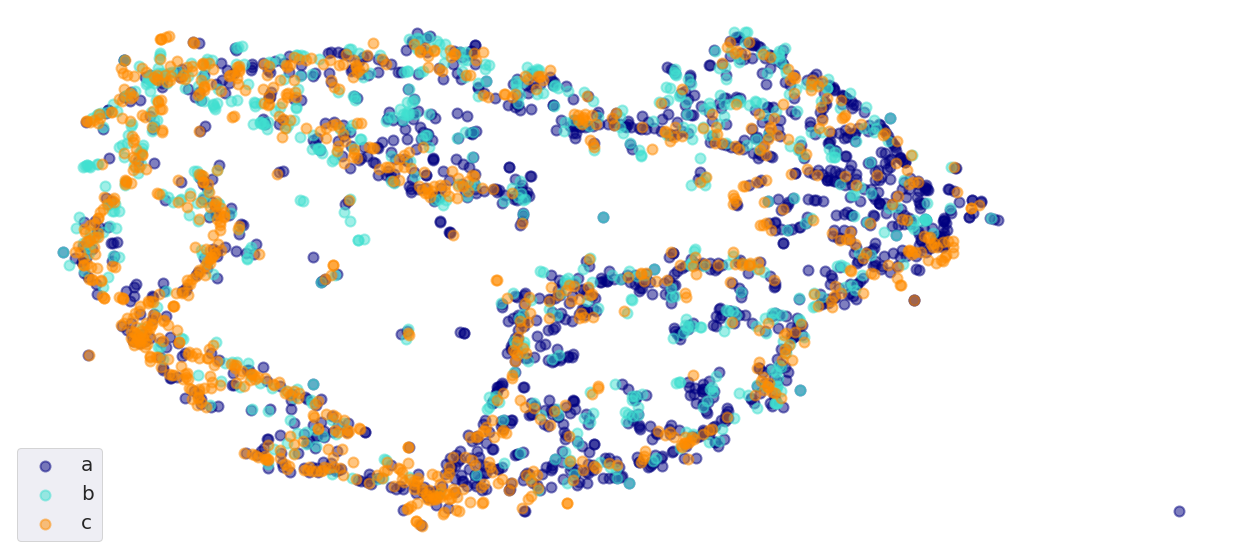

(<Figure size 1584x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f565feea2b0>)

In [17]:
def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 20})
    ax.axis('off')
    ax.axis('tight') 
    plt.show()

    return f, ax


target_names = ['a', 'b', 'c']
plotter(redu, y_train[:3000], target_names) 